In [8]:
import cupy as cp
import numpy as np
from numpy import linspace, sign, prod, tanh, cosh, cos, tan, arange
from math import sqrt, pi
from matplotlib import pyplot as plt
import numba
from numba import prange
from functools import lru_cache

In [9]:
@numba.njit(cache=True)
def factorial(x):
    n = 1
    for i in range(2, x+1):
        n *= i
    return n

@numba.njit(cache=True)
def comb(n, k):
    return factorial(n) / (factorial(k) * factorial(n - k))


@numba.njit(cache = True)
def W(i1,j1,k1,l1,i2,j2,k2,l2,alpha,delta):
    A = 0
    for mu in range(0, i1+1):
        for nu in range(0, j1+1):
            for kappa in range(0,k1+1):
                for lamda in range(0,l1+1):
                    for na in range(0, min(j2,nu+kappa)+1):
                        for nd in range(0, min(k2,j1+k1-(nu+kappa))+1):
                            A = A + (
                                1/(sqrt(2)**(i1+j1+k1+l1) * sqrt(factorial(i1) * factorial(j1) * factorial(k1) * factorial(l1))) * 
                                (-1)**(mu+nu) * comb(i1,mu) * comb(j1,nu) * comb(k1,kappa) * comb(l1,lamda) * 
                                int(mu+nu+kappa+lamda == (i2+j2)) * int(i1+j1+k1+l1 == (i2+j2+k2+l2)) * 
                                sqrt(factorial(mu+lamda) * factorial(nu+kappa) * factorial(i1+l1-mu-lamda) * factorial(j1+k1-nu-kappa))*
                                cos(alpha/2)**(i2+j2-2*na) * cos(delta/2)**(k2+l2-2*nd) * 
                                ((1j*tan(alpha/2))**(j2+nu+kappa-2*na) * (1j*tan(delta/2))**(k2+j1+k1-nu-kappa-2*nd) / (factorial(j2-na) * factorial(nu+kappa-na) * factorial(k2-nd) * factorial(j1+k1-nu-kappa-nd)))*
                                sqrt(
                                    prod(na+arange(1, j2-na+1))* #  m1
                                    prod(na+arange(1, nu+kappa-na+1))* # m2
                                    prod(i2+arange(1, j2-na+1))* # m3
                                    prod(i2+j2-nu-kappa+arange(1, nu+kappa-na+1))* # m4
                                    prod(nd+arange(1, k2-nd+1))* # m5
                                    prod(nd+arange(1, j1+k1-nu-kappa-nd+1))* # m6
                                    prod(l2+arange(1, k2-nd+1))* # m7
                                    prod(k2+l2-j1-k1+nu+kappa+arange(1, j1+k1-nu-kappa-nd+1)) # m8
                                )
                            )
    return abs(A) ** 2

@numba.njit(cache=True)
def det_p(out, input, eta, dc):
    p = (1-dc) * (1-eta * (1-dc))**input
    if out == 1:
        p = 1-p
    return p
    
@numba.njit(cache=True)
def h(chi, eta, dc):
    return (1-eta*(1-dc)) * tanh(chi)**2

@numba.njit(cache=True)
def f(out, input, chi, eta, dc):
    if out == 0:
        ret_f = (h(chi, eta, dc)**input) * (1-h(chi, eta, dc))
    else: 
        ret_f = ( tanh(chi)**(2*input) - (1-dc) * h(chi, eta, dc)**input ) / ( cosh(chi)**2 - (1-dc)/(1-h(chi, eta, dc)) )
    return ret_f

In [10]:
# @numba.njit(parallel=True)
def run_simulations(alpha_list, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc):
    fringe = []
    for alpha in alpha_list:
        for delta in delta_list:
            Q = 0
            for input_condition in range(len(qrst_1)):
                q1 = qrst_1[input_condition][0]
                r1 = qrst_1[input_condition][1]
                s1 = qrst_1[input_condition][2]
                t1 = qrst_1[input_condition][3]
                for output_condition in range(len(qrst_2)):
                    q2 = qrst_2[output_condition][0]
                    r2 = qrst_2[output_condition][1]
                    s2 = qrst_2[output_condition][2]
                    t2 = qrst_2[output_condition][3]
                    for i2 in range(0, trunc+1):
                        for j2 in range(0, trunc+1):
                            for k2 in range(0, trunc+1):
                                for l2 in range(0, trunc+1):
                                    remote_det_p = det_p(q2, i2, eta2, dc2_1_12) * det_p(r2, j2, eta2, dc2_1_12) * det_p(s2, k2, eta2, dc2_1_12) * det_p(t2, l2, eta2, dc2_1_12)
                                    for i1 in range(0, trunc+1):
                                        for j1 in range(0, trunc+1):
                                            for k1 in range(0, trunc+1):
                                                for l1 in range(0, trunc+1):
                                                    Q = Q + (
                                                                # remote_det_p * 
                                                                W(i1,j1,k1,l1,i2,j2,k2,l2,alpha,delta) # * 
                                                                # f(q1, i1, chi, eta1_12, dc2_1_12) * f(r1, j1, chi, eta1_12, dc2_1_12) * f(s1, k1, chi, eta1_34, dc1_34) * f(t1, l1, chi, eta1_34, dc1_34) 
                                                            )
            fringe.append(Q)
    return fringe

In [11]:
# % params
# alpha_list_1 = [0]
# alpha_list_2 = [pi/2]

alpha_list = linspace(0, pi, 5)

delta_list = linspace(0,np.pi-1e-3,20)
# delta_list = [np.pi/2, 3*np.pi/2]
# delta_list = [np.pi/2]

chi = sqrt(0.06)

dc1_34 = 1*10**(-5)
dc2_1_12 = 3 * 10**(-5)

eta1_12 = 0.045
eta1_34 = 0.135
eta2 = 0.04

qrst_1 = [[1,0,1,0],[0,1,0,1]]
# qrst_1 = [[1,0,1,0]]
qrst_2 = [[0,1,1,0],[1,0,0,1]]
# qrst_2 = [[0,1,1,0]]

trunc = 2

In [12]:
# Trying stuff out
# fringe1 = run_simulations(alpha_list, delta_list, chi, 0, 0, 1, 1, 1, qrst_1, qrst_2, trunc)
# fringe2 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.5, 0.5, 0.5, qrst_1, qrst_2, trunc)
# fringe3 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.005, 0.005, 0.005, qrst_1, qrst_2, trunc)

# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)

fringe_real = []
for alpha in alpha_list:
    print(alpha)
    fringe = run_simulations([alpha], delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
    fringe_real.append(fringe)


# Actual simulation
# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)


0.0
0.3490658503988659
0.6981317007977318
1.0471975511965976
1.3962634015954636
1.7453292519943295
2.0943951023931953
2.443460952792061
2.792526803190927
3.141592653589793


In [13]:
# visibility_real_1 = (max(fringe_real_1) - min(fringe_real_1)) / (max(fringe_real_1) + min(fringe_real_1))
# visibility_real_2 = (max(fringe_real_2) - min(fringe_real_2)) / (max(fringe_real_2) + min(fringe_real_2))

# print(visibility_real_1, fringe_real_1)
# print(visibility_real_2, fringe_real_2)

[182.25, 181.88697098703028, 180.86503973852814, 179.36666705913922, 177.63960275094496, 175.9340284571683, 174.44885038442885, 173.3041747075995, 172.5454683502468, 172.17171893335302, 172.1706007010106, 172.54206321570953, 173.29840911742403, 174.44082205518302, 175.92421776798798, 177.62898469582814, 179.35664252547747, 180.85717801594714, 181.88263597381558, 182.24998650000714]
[180.7169828182419, 180.37983857879723, 179.43124792153603, 178.0418342359806, 176.44290970127292, 174.86735287316915, 173.49921916822208, 172.44814920402746, 171.75373153547844, 171.41250427122452, 171.41148432046185, 171.7506199087827, 172.44286455963763, 173.4918357123216, 174.85830225544768, 176.4330893480819, 178.03254502899372, 179.4239532758979, 180.3758131748592, 180.71697027857016]
[177.2482860750432, 176.97064954986126, 176.19318767636818, 175.06554187597698, 173.787759281404, 172.5557853553781, 171.51598208902504, 170.7438225760417, 170.25136827756359, 170.0161230240157, 170.0154276071762, 170.249

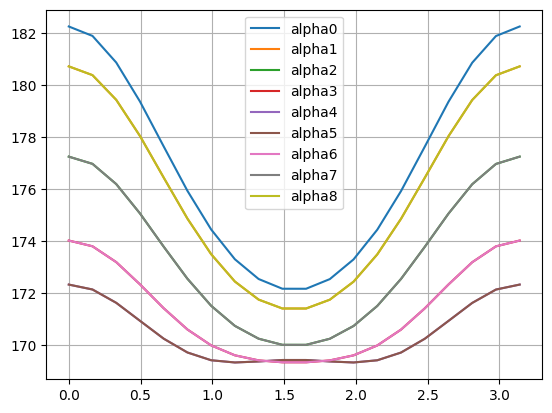

In [14]:
# plt.grid(True)
# plt.plot(delta_list, fringe1)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe2)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe3)

plt.figure()
plt.grid(True)
for i in range(len(alpha_list)-1):
    print(fringe_real[i])
    plt.plot(delta_list, fringe_real[i], label=f'alpha{i}')
# plt.plot(delta_list, fringe_real_1, label='alpha1')
# plt.plot(delta_list, fringe_real_2, label='alpha2')
plt.legend()

In [23]:
# % params
# alpha_list_1 = [0]
# alpha_list_2 = [pi/2]

alpha_list = linspace(0, pi, 10)

delta_list = linspace(0,np.pi-1e-3,20)
# delta_list = [np.pi/2, 3*np.pi/2]
# delta_list = [np.pi/2]

chi = sqrt(0.06)

dc1_34 = 1*10**(-5)
dc2_1_12 = 3 * 10**(-5)

eta1_12 = 0.045
eta1_34 = 0.135
eta2 = 0.04

# qrst_1 = [[1,0,1,0],[0,1,0,1]]
qrst_1 = [[1,0,1,0]]
# qrst_2 = [[0,1,1,0],[1,0,0,1]]
qrst_2 = [[0,1,1,0]]

trunc = 1

In [24]:
# Trying stuff out
# fringe1 = run_simulations(alpha_list, delta_list, chi, 0, 0, 1, 1, 1, qrst_1, qrst_2, trunc)
# fringe2 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.5, 0.5, 0.5, qrst_1, qrst_2, trunc)
# fringe3 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.005, 0.005, 0.005, qrst_1, qrst_2, trunc)

# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)

fringe_real = []
for alpha in alpha_list:
    print(alpha)
    fringe = run_simulations([alpha], delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
    fringe_real.append(fringe)


# Actual simulation
# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)


0.0
0.3490658503988659
0.6981317007977318
1.0471975511965976
1.3962634015954636
1.7453292519943295
2.0943951023931953
2.443460952792061
2.792526803190927
3.141592653589793


In [25]:
# visibility_real_1 = (max(fringe_real_1) - min(fringe_real_1)) / (max(fringe_real_1) + min(fringe_real_1))
# visibility_real_2 = (max(fringe_real_2) - min(fringe_real_2)) / (max(fringe_real_2) + min(fringe_real_2))

# print(visibility_real_1, fringe_real_1)
# print(visibility_real_2, fringe_real_2)

[9.0, 9.0, 8.999999999999998, 9.0, 8.999999999999993, 8.999999999999993, 8.999999999999998, 8.999999999999998, 8.999999999999998, 9.0, 8.999999999999998, 8.999999999999998, 8.999999999999998, 8.999999999999998, 9.000000000000002, 9.0, 9.0, 8.999999999999998, 8.999999999999996, 9.0]
[9.0, 9.00079177264222, 9.003081343833024, 9.006620759493535, 9.011026710926755, 9.015822046064423, 9.020487443685292, 9.024517654433387, 9.027476217893039, 9.02904273001636, 9.029047541974744, 9.02749013264671, 9.024539165053923, 9.02051422063336, 9.015851189472361, 9.01105506464597, 9.006645252896506, 9.003099324353544, 9.0008012930408, 9.000000029244454]
[9.0, 9.002796611350036, 9.010883580307308, 9.023385111025569, 9.03894732311616, 9.055884873061695, 9.072363472148256, 9.086598534740817, 9.09704844385585, 9.102581503916797, 9.102598500181518, 9.097097592002656, 9.086674512164526, 9.072458050708953, 9.055987810168983, 9.039047470972701, 9.023471623901989, 9.010947089103986, 9.002830238244067, 9.000000103

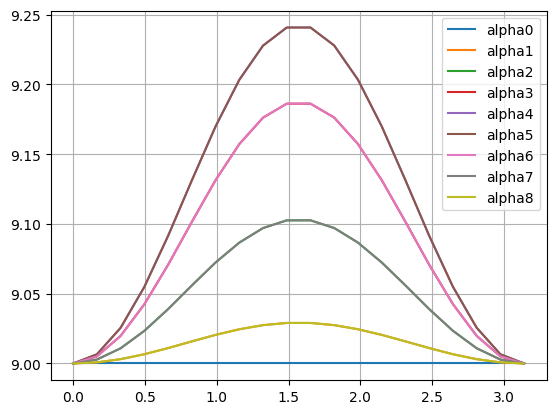

In [26]:
# plt.grid(True)
# plt.plot(delta_list, fringe1)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe2)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe3)

plt.figure()
plt.grid(True)
for i in range(len(alpha_list)-1):
    print(fringe_real[i])
    plt.plot(delta_list, fringe_real[i], label=f'alpha{i}')
# plt.plot(delta_list, fringe_real_1, label='alpha1')
# plt.plot(delta_list, fringe_real_2, label='alpha2')
plt.legend()

In [27]:
# % params
# alpha_list_1 = [0]
# alpha_list_2 = [pi/2]

alpha_list = linspace(0, pi, 5)

delta_list = linspace(0,np.pi-1e-3,20)
# delta_list = [np.pi/2, 3*np.pi/2]
# delta_list = [np.pi/2]

chi = sqrt(0.06)

dc1_34 = 1*10**(-5)
dc2_1_12 = 3 * 10**(-5)

eta1_12 = 0.045
eta1_34 = 0.135
eta2 = 0.04

# qrst_1 = [[1,0,1,0],[0,1,0,1]]
qrst_1 = [[1,0,1,0]]
# qrst_2 = [[0,1,1,0],[1,0,0,1]]
qrst_2 = [[0,1,1,0]]

trunc = 3

In [28]:
# Trying stuff out
# fringe1 = run_simulations(alpha_list, delta_list, chi, 0, 0, 1, 1, 1, qrst_1, qrst_2, trunc)
# fringe2 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.5, 0.5, 0.5, qrst_1, qrst_2, trunc)
# fringe3 = run_simulations(alpha_list, delta_list, chi, 0, 0, 0.005, 0.005, 0.005, qrst_1, qrst_2, trunc)

# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)

fringe_real = []
for alpha in alpha_list:
    print(alpha)
    fringe = run_simulations([alpha], delta_list, chi, 0, 0, 0.9, 0.9, 0.9, qrst_1, qrst_2, trunc)
    fringe_real.append(fringe)


# Actual simulation
# fringe_real_1 = run_simulations(alpha_list_1, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)
# fringe_real_2 = run_simulations(alpha_list_2, delta_list, chi, dc1_34, dc2_1_12, eta1_12, eta1_34, eta2, qrst_1, qrst_2, trunc)


0.0
0.7853981633974483
1.5707963267948966
2.356194490192345
3.141592653589793


In [29]:
# visibility_real_1 = (max(fringe_real_1) - min(fringe_real_1)) / (max(fringe_real_1) + min(fringe_real_1))
# visibility_real_2 = (max(fringe_real_2) - min(fringe_real_2)) / (max(fringe_real_2) + min(fringe_real_2))

# print(visibility_real_1, fringe_real_1)
# print(visibility_real_2, fringe_real_2)

[138.0625, 137.94684373674428, 137.58781533135038, 136.9678368961617, 136.10403288094759, 135.0764151885827, 134.02020662008033, 133.0869882750613, 132.401868856898, 132.04217117889462, 132.04107127667118, 132.39866120203158, 133.0819941759673, 134.0140443916798, 135.0699570293927, 136.0981943457025, 136.9632976108767, 137.58485774106356, 137.94542560081007, 138.06249581389164]
[135.34033203124997, 135.26510841552695, 135.01614102959766, 134.55061946537936, 133.86393812125604, 133.0279911060357, 132.1767385945413, 131.4503728087713, 130.9423965651445, 130.68710526986888, 130.68633849494645, 130.9400819169817, 131.44658117691705, 132.17184345247017, 133.02273582159427, 133.85921709888186, 134.54709903610154, 135.01401155453718, 135.26416847566404, 135.34032726773094]
[131.99609375, 131.95408938187683, 131.80271117025305, 131.4983184981975, 131.04483850461222, 130.52767569020511, 130.0775345711524, 129.78995599083316, 129.6687658997657, 129.6430170792881, 129.64298325344373, 129.66841205

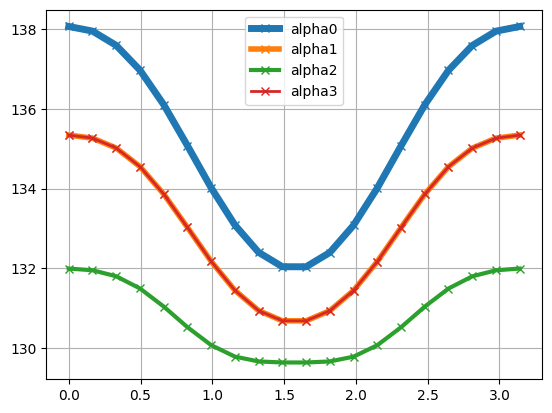

In [36]:
# plt.grid(True)
# plt.plot(delta_list, fringe1)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe2)

# plt.figure()
# plt.grid(True)
# plt.plot(delta_list, fringe3)

plt.figure()
plt.grid(True)
for i in range(len(alpha_list)-1):
    print(fringe_real[i])
    plt.plot(delta_list, fringe_real[i], '-x', linewidth = 5-i,  label=f'alpha{i}')
# plt.plot(delta_list, fringe_real_1, label='alpha1')
# plt.plot(delta_list, fringe_real_2, label='alpha2')
plt.legend()